## Импортирование библиотек

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import networkx.algorithms.community as nx_comm

## Алгоритм

### Label Propagation

In [ ]:
def LabelPropagation(P, Y, eps, max_iter, labelled):

    '''
    P :[array]
    матрица перехода

    Y :[matrix] 
    матрица вероятностей

    eps:[int] 
    точность

    max:[int] 
    максимальное количество итераций

    labelled :[list]
    список помеченных вершин

    '''

    Y_initial = Y # сохраняем изначальную матрицу
    Y_current = Y # инициализируем матрицу
    
    n=0

    current_eps = sys.maxsize # задаем текущее значение точности
    
    while current_eps > eps or n < max_iter:
        
        current_eps = 0.0
        Y0 = Y_current
        
        Y_current = P*Y0 # умножаем на матрицу перехода

        for i in range(Y_initial.shape[0]): # восстанавливаем веса для размеченных вершин
            if i in labelled:
                for j in range(Y_initial.shape[1]):
                    Y_current.A[i][j] = Y_initial.A[i][j]

        for i in range(Y_current.shape[0]): # текущее значение точности
            for j in range(Y_current.shape[1]):
                current_eps += abs(Y_current.A[i][j] - Y0.A[i][j])
        
        n += 1
        
    return Y_current

### Walktrap

In [ ]:
def Reachable( i , theta_cores , Fuzz_D , visited ):

    reach = []
    flag = True
    index = -1
    num_cores = len(theta_cores)
    while(flag):
        if(index == len(reach)):
            flag = False
        if(index == -1):
            flag = False
            for j in range(num_cores):
                if(visited[j] == 0 and i != j):
                    if(Fuzz_D[theta_cores[i]][theta_cores[j]]>0):
                        visited[j] = 1
                        reach.append(j)
                        flag = True
        else:
            for j in range(num_cores):
                if(visited[j] == 0 and index != j):
                    if(Fuzz_D[theta_cores[index]][theta_cores[j]]>0):
                        visited[j] = 1
                        reach.append(j)
                        flag = True
        index += 1
    return np.array(reach)
                
def GranEmbed( core , C , Fuzz_D ):

    num = 0
    den = 0
    C = np.array(C)
    C = np.append(C,core)
    n = len(Fuzz_D[0])
    for i in range(n):
        num += np.min(Fuzz_D[C,i])
        den += np.max(Fuzz_D[C,i])
    return float(num)/den

def Walktrap( AdjacencyMat , eps , r ):

    theta = 1  
    theta_cores = []
    num_vertices = AdjacencyMat.shape[0]
    
    gran = [ i for i in range(num_vertices) ]

    G = nx.from_numpy_matrix( AdjacencyMat )
    Dist = dict(nx.all_pairs_shortest_path_length(G))

    Fuzz_D = np.zeros( shape = AdjacencyMat.shape ).astype(float)
    for i in range( num_vertices ):
        for j in range( num_vertices ):
            if(Dist[i][j] <= r):
                Fuzz_D[i][j] = 1/float(1 + Dist[i][j])
    Sum = np.sum(Fuzz_D, axis = 1 )

    for i in range( num_vertices ):
            Fuzz_D[i] = Fuzz_D[i] / float(Sum[i]) 

    for i in range( num_vertices ):
        if(np.sum(Fuzz_D[:,i]) >= theta):
            theta_cores.append(i)
    theta_cores = np.array(theta_cores)
    num_cores = len( theta_cores )
    Sum = np.sum(Fuzz_D[:, theta_cores ], axis = 1 )
    k = 0
    for i in range(num_vertices):
        Fuzz_D[i] = Fuzz_D[i]/Sum[k]
        k += 1

    Communities = []
    visited = np.zeros( num_cores )
    for i in range( num_cores ):
        if( visited[i] == 0 ):
            C = []
            C.append(theta_cores[i])
            visited[i] = 1
            Reach = Reachable( i , theta_cores , Fuzz_D , visited.copy() )
            for core_ind in Reach:
                if( GranEmbed( theta_cores[ core_ind ] , C , Fuzz_D ) > eps ):
                    C.append( theta_cores[ core_ind ] )
                    visited[ core_ind ] = 1
            Communities.append( C )
            
    Communities =  np.array(Communities)
    result = np.empty((num_vertices,len(Communities)))
    for i in range(num_vertices):
        for j in range(len(Communities)):
            result[i][j] = np.sum(Fuzz_D[i,Communities[j]])
                
    return result

## Karate Club

### Предварительная обработка

In [ ]:
gkc = nx.karate_club_graph()
gkc_pos=nx.spring_layout(gkc, seed=40)

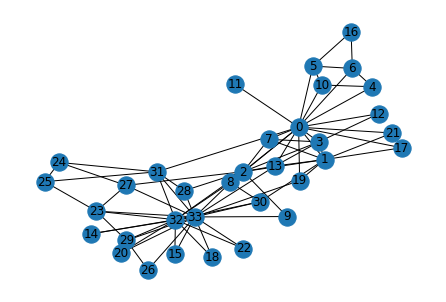

In [ ]:
nx.draw(gkc,pos=gkc_pos,with_labels=True)

In [ ]:
col = []
for i in nx.get_node_attributes(gkc, 'club').values():
  if i =='Mr. Hi':
    col.append(1)
  else:
    col.append(2)

In [ ]:
label = dict() # создаем словарь, в котором ключом является вершина, а значением ее класс
for i,j in nx.get_node_attributes(gkc, 'club').items():
  if j =='Mr. Hi':
    label[i] = 0
  else:
    label[i] = 1 

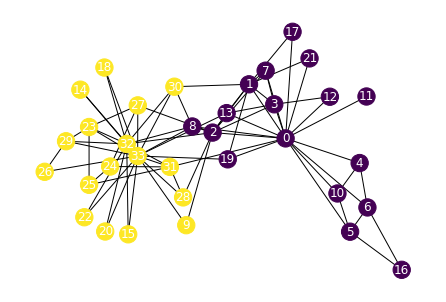

In [ ]:
nx.draw(gkc,with_labels=True, node_color=col,font_color ='white')

### Label Propogation

In [ ]:
G_club = pd.Series(nx.get_node_attributes(gkc, 'club')) 
G_club.head(5)

0    Mr. Hi
1    Mr. Hi
2    Mr. Hi
3    Mr. Hi
4    Mr. Hi
dtype: object

In [ ]:
res_k_2 = []

# зафиксируем размер обучающей выборки на 5%

# Зададим значения для оптимизации гиперпараметров

epsilons = [10**2,10**1,10**0,10**-1,10**-2,10**-3,10**-4]
iterations = list(np.arange(100)+1)

for eps in epsilons:

  percent = 0.05

  max_acc_2 = 0
  max_mod = 0
  best_param_2 = iterations[0]

  for iter in iterations:

    acc = []
    mod = []

    for quantity in range(5):

      # выбираем вершины
      class_1 = G_club[G_club == 'Mr. Hi'].sample(round(len(G_club[G_club == 'Mr. Hi'])*percent)).index.to_list() 
      class_2 = G_club[G_club == 'Officer'].sample(round(len(G_club[G_club == 'Officer'])*percent)).index.to_list()
      other = G_club[G_club.index.isin(class_1 + class_2) == False].index.to_list() 

      # матрица смежности
      A = nx.adjacency_matrix(gkc, nodelist=class_1 + class_2 + other).toarray()
      for i in range(len(class_1 + class_2)):
        A[i] = 0
        A[i][i] = 1

      D = np.diag(A.sum(axis=1))

      # матрица перехода
      P = np.linalg.inv(D) @ A

      data_label = np.zeros((len(class_1 + class_2),2))
      for i in range(len(data_label)):
        if i < len(class_1):
          data_label[i][0]=1
        else:
          data_label[i][1]=1

      # матрица вероятностей
      Y = np.zeros((len(P),2))
      Y[:len(class_1 + class_2)] = data_label
      Y[len(class_1 + class_2):] = 0
      Y = np.matrix(Y)

      L = LabelPropagation(P, Y, eps, iter, np.arange(len(class_1 + class_2))).argmax(1) 

      # создаем словарь, в котором ключом является вершина, а значением ее класс
      new_label = dict()
      nodes_1 = class_1 + class_2 + other
      for i in range(len(Y)):
        new_label[nodes_1[i]] = int(L[i])

      score = 0
      for i in label.keys():
        if new_label[i] == label[i]:
          score += 1

      Accuracy = round(score/len(label.keys()),4)

      m = [[],[]]
      for r,t in new_label.items():
        if t == 0:
          m[0].append(r)
        else:
          m[1].append(r)    
      m = [set(m[0]),set(m[1])]
      mod.append(round(nx_comm.modularity(gkc, m),4))

      acc.append(Accuracy)

    if np.mean(acc) > max_acc_2:
      max_acc_2 = np.mean(acc)
      max_mod = np.mean(mod)
      best_param_2 = iter

  res_k_2.append([eps,best_param_2,max_acc_2,max_mod])

In [ ]:
res_k_2

[[100, 24, 0.96472, 0.36857999999999996],
 [10, 69, 0.9353, 0.32887999999999995],
 [1, 60, 0.96472, 0.36766],
 [0.1, 9, 0.9705999999999999, 0.3715],
 [0.01, 47, 0.8411800000000001, 0.27806],
 [0.001, 51, 0.91766, 0.34758],
 [0.0001, 46, 0.88824, 0.30772000000000005]]

In [ ]:
eps = []
for i in res_k_2:
  eps.append(i[0])
acc = []
for i in res_k_2:
  acc.append(i[2])
mod = []
for i in res_k_2:
  mod.append(i[3]) 

#### Графическое представление

Text(0.5, 1.0, 'Точность')

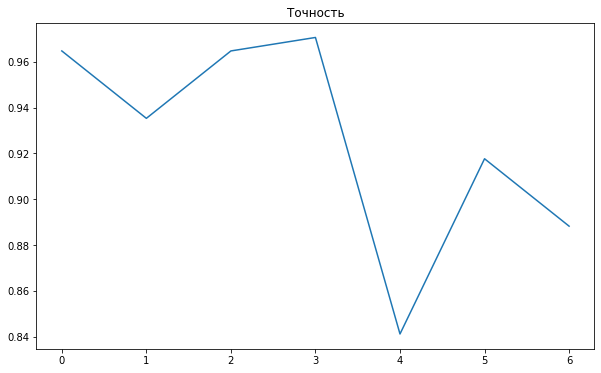

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(np.arange(len(eps)),acc)
plt.title("Точность")

Text(0.5, 1.0, 'Модулярность')

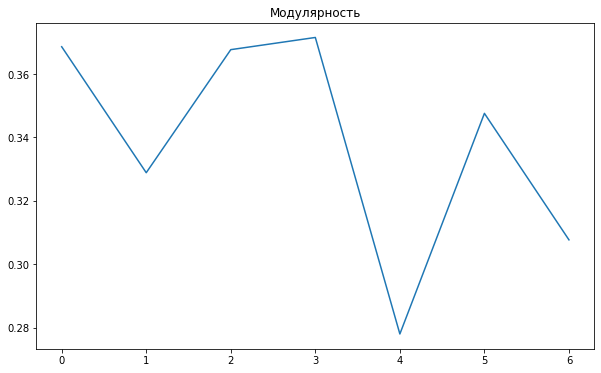

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(np.arange(len(eps)),mod)
plt.title('Модулярность')

### Walktrap

In [ ]:
res_k_3 = []

# Зададим значения для оптимизации гиперпараметров

epsilons = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
r = list(np.arange(9)+1)

for eps in epsilons:

  max_acc_2 = 0
  best_param_2 = r[0]
  max_mod = 0

  for iter in r:

    acc = []
    mod = []

    for quantity in range(5):

      # матрица смежности
      A = nx.adjacency_matrix(gkc).toarray()

      W = np.argmax(Walktrap(A, eps, iter),axis = 1)

      # создаем словарь, в котором ключом является вершина, а значением ее класс
      new_label = dict()
      nodes_1 = list(gkc.nodes())
      for i in nodes_1:
        new_label[i] = int(W[i])

      score = 0
      for i in label.keys():
        if new_label[i] == label[i]:
          score += 1

      Accuracy = round(score/len(label.keys()),4)

      acc.append(Accuracy)

      m = [[],[]]
      for p,t in new_label.items():
        if t == 0:
          m[0].append(p)
        else:
          m[1].append(p)    
      m = [set(m[0]),set(m[1])]
      mod.append(nx_comm.modularity(gkc, m))

    if np.mean(acc) > max_acc_2:
      max_acc_2 = np.mean(acc)
      max_mod = np.mean(mod)
      best_param_2 = iter

  res_k_3.append([eps,best_param_2,max_acc_2,max_mod])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
res_k_3

[[0.1, 2, 0.5, 0.0],
 [0.2, 2, 0.5, 0.0],
 [0.3, 2, 0.9118, 0.304404996712689],
 [0.4, 2, 0.5, 0.3266765285996055],
 [0.5, 3, 1.0, 0.3582347140039448],
 [0.6, 3, 0.7941, 0.3569197896120973],
 [0.7, 4, 0.3824, 0.24260355029585795],
 [0.8, 1, 0.3529, 0.10815253122945431],
 [0.9, 1, 0.3529, 0.10815253122945431],
 [1, 1, 0.3529, 0.10815253122945431]]

In [ ]:
eps = []
for i in res_k_3:
  eps.append(i[0])
acc = []
for i in res_k_3:
  acc.append(i[2])
mod = []
for i in res_k_3:
  mod.append(i[3]) 

#### Графическое представление

Text(0.5, 1.0, 'Accuracy')

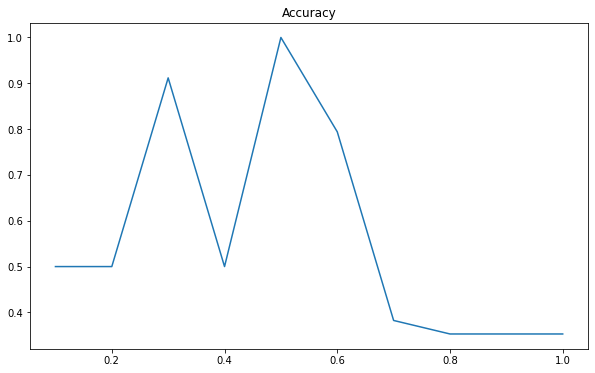

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(eps,acc)
plt.title("Accuracy")

Text(0.5, 1.0, 'Модулярность')

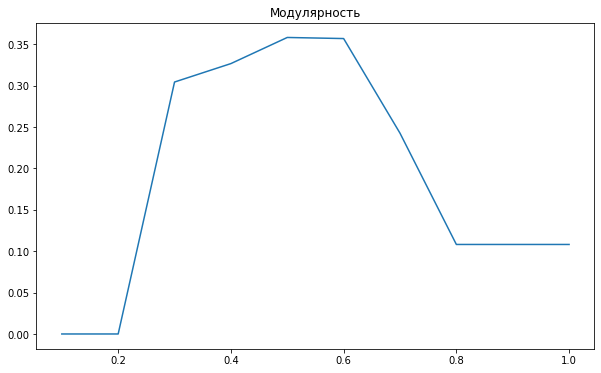

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(eps,mod)
plt.title('Модулярность')

## Internet industry partnership

### Предварительная обработка

In [ ]:
G = nx.read_edgelist('/content/drive/MyDrive/Colab Notebooks/Курсовая 2/internet-industry-partnerships.edges', delimiter=',' )
len(G),len(G.edges())

(219, 630)

In [ ]:
G_int_pos=nx.shell_layout(G)

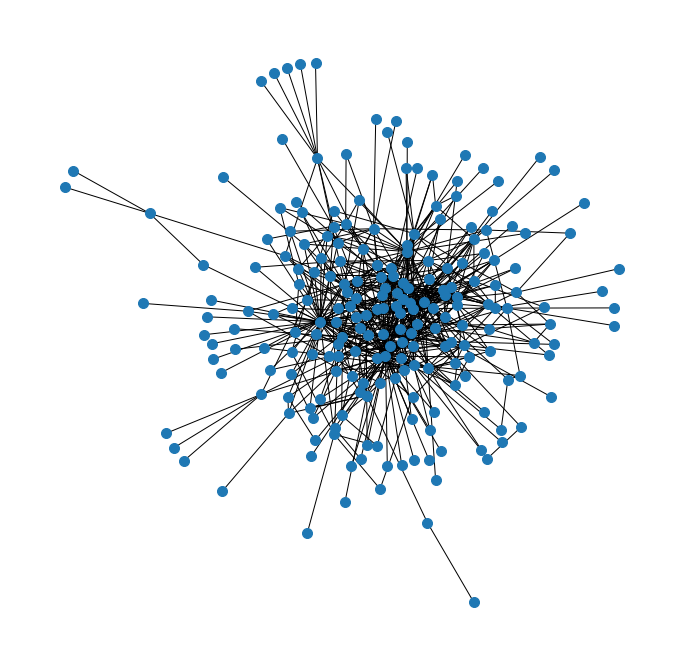

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw(G,node_size=100)

In [ ]:
attributes = [1,2,2,1,2,2,3,3,3,2,2,1,3,3,3,1,3,2,1,2,2,2,1,2,1,1,2,2,1,3,3,2,2,2,2,2,1,3,1,3,2,1,3,1,1,2,2,2,2,2,2,3,3,3,1,1,2,2,2,2,1,2,2,2,3,2,1,1,3,1,3,3,3,2,3,2,3,1,2,2,2,1,2,2,2,2,2,2,2,2,1,2,2,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,2,2,2,2,2,1,2,2,3,2,2,2,2,2,3,1,2,2,2,3,2,3,2,2,2,3,2,2,2,1,2,2,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,2,1,2,2,2,1,3,3,3,2,2,1,1,1,1,1,2,2,1,2,2,1,2,3,2,2,2,2,1,3,3,2,2,3,2,2,1,3,3,2,2,3,1,2,3]
attr = dict()
count = 0
for i in G.nodes(): # создаем атрибуты графа
  attr[i] = {'label':attributes[count]}
  count+=1
nx.set_node_attributes(G,attr)

In [ ]:
label = dict() # создаем словарь, в котором ключом является вершина, а значением ее класс
for i,j in nx.get_node_attributes(G, 'label').items():
  if j == 1:
    label[i] = 0
  elif j == 2:
    label[i] = 1
  else:
    label[i] = 2 

### Label Propogation

In [ ]:
G_club = pd.Series(nx.get_node_attributes(G, 'label')) 
G_club.head(5)

3      1
216    2
203    2
215    1
153    2
dtype: int64

In [ ]:
res_i_2 = []

# зафиксируем размер обучающей выборки на 5%

# Зададим значения для оптимизации гиперпараметров

epsilons = [10**2,10**1,10**0,10**-1,10**-2,10**-3,10**-4]
iterations = list(np.arange(100)+1)

for eps in epsilons:

  percent = 0.05

  max_acc_2 = 0
  max_mod = 0
  best_param_2 = iterations[0]

  for iter in iterations:

    acc = []
    mod = []

    for quantity in range(5):
        
      # выбираем вершины 
      class_1 = G_club[G_club == 1].sample(round(len(G_club[G_club == 1])*percent)).index.to_list() 
      class_2 = G_club[G_club == 2].sample(round(len(G_club[G_club == 2])*percent)).index.to_list()
      class_3 = G_club[G_club == 3].sample(round(len(G_club[G_club == 3])*percent)).index.to_list()
      other = G_club[G_club.index.isin(class_1 + class_2 + class_3) == False].index.to_list() 

      # матрица смежности
      A = nx.adjacency_matrix(G, nodelist=class_1 + class_2 + class_3 + other).toarray()
      for i in range(len(class_1 + class_2 + class_3)):
        A[i] = 0
        A[i][i] = 1

      D = np.diag(A.sum(axis=1))

      # матрица перехода
      P = np.linalg.inv(D) @ A

      data_label =  np.zeros((len(class_1 + class_2 + class_3),3))
      for i in range(len(data_label)):
        if i < len(class_1):
          data_label[i][0]=1
        elif i >= len(class_1) and i < len(class_1 + class_2):
          data_label[i][1]=1
        else:
          data_label[i][2]=1

      # матрица вероятностей
      Y = np.zeros((len(P),3))
      Y[:len(class_1 + class_2 + class_3)] = data_label
      Y[len(class_1 + class_2 + class_3):] = 0
      Y = np.matrix(Y)

      L = LabelPropagation(P, Y, eps, iter, np.arange(len(class_1 + class_2 + class_3))).argmax(1) 
      
      # создаем словарь, в котором ключом является вершина, а значением ее класс
      new_label = dict()
      nodes_1 = class_1 + class_2 + class_3 + other
      for i in range(len(Y)):
        new_label[nodes_1[i]] = int(L[i])

    
      score = 0
      for i in label.keys():
        if new_label[i] == label[i]:
          score += 1

      Accuracy = round(score/len(label.keys()),4)

      acc.append(Accuracy)

      m = [[],[]]
      for r,t in new_label.items():
        if t == 0:
          m[0].append(r)
        else:
          m[1].append(r)    
      m = [set(m[0]),set(m[1])]
      mod.append(round(nx_comm.modularity(G, m),4))

    if np.mean(acc) > max_acc_2:
      max_acc_2 = np.mean(acc)
      max_mod = np.mean(mod)
      best_param_2 = iter

  res_i_2.append([eps,best_param_2,max_acc_2,max_mod])

In [ ]:
res_i_2

[[100, 60, 0.62376, 0.00208],
 [10, 51, 0.62556, 0.00242],
 [1, 68, 0.62466, 0.0006000000000000001],
 [0.1, 94, 0.62556, 0.0024800000000000004],
 [0.01, 22, 0.62648, 0.00182],
 [0.001, 19, 0.62648, 0.0036200000000000004],
 [0.0001, 10, 0.6274, 0.0024000000000000002]]

#### Графическое представление

In [ ]:
eps = []
for i in res_i_2:
  eps.append(i[0])
acc = []
for i in res_i_2:
  acc.append(i[2])
mod = []
for i in res_i_2:
  mod.append(i[3])  

Text(0.5, 1.0, 'Точность')

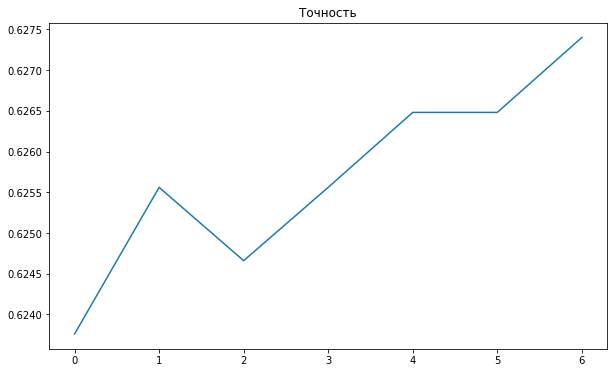

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(np.arange(len(eps)),acc)
plt.title("Точность")

Text(0.5, 1.0, 'Модулярность')

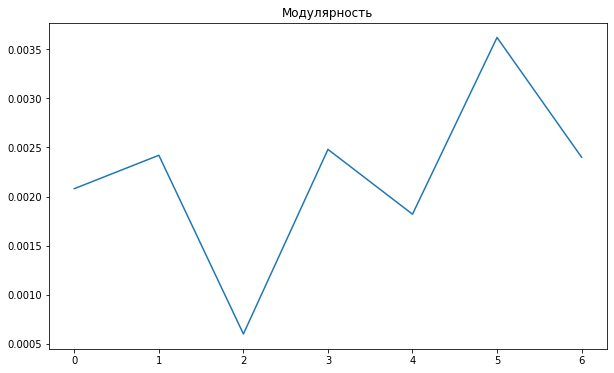

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(np.arange(len(eps)),mod)
plt.title('Модулярность')